# Prediction model for what is a "good wine" and a "bad wine"

## The prediction model is trained on and uses the data available at: [Wine Data](https://www.kaggle.com/datasets/piyushagni5/white-wine-quality)

### All credits to:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

## Needed Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from itertools import combinations
#plt.style.use('fivethirtyeight')

In [38]:
from fastai.tabular.core import cont_cat_split

# sklearn
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import set_config


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# yellow bricks
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.classifier.rocauc import roc_auc
from yellowbrick.classifier import precision_recall_curve

In [39]:
from pycaret.datasets import get_data
from pycaret import classification
from pycaret import regression
from pycaret import arules
from pycaret.classification import predict_model

## Auxiliary Function

### Provided by [Leonardo Tavares](https://www.kaggle.com/leodaniel/)

In [40]:
def basic_info(df:pd.DataFrame)->str:
    
    s = ""
    count = 1
    for c in df.columns:
        nan = df[c].isna().sum()
        shape = df.shape[0]

        
        s+= f"{count} - {c}\n"
        s+= f"    Type: {df[c].dtype}\n"
        s+= f"    No. of unique values {df[c].nunique()}\n"
        s+= f"    Sample of unique values {df[c].unique()[0:10]}\n"
        s+= f"    Null values {nan} ({np.round((nan/shape)*100, 2)} %)\n"
        s+= "\n"
        count += 1
    return s

In [41]:
df = pd.read_csv('archive/winequality-white.csv',sep=';')

## Exploratory data analysis

In [42]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [43]:
print(basic_info(df))

1 - fixed acidity
    Type: float64
    No. of unique values 68
    Sample of unique values [7.  6.3 8.1 7.2 6.2 8.6 7.9 6.6 8.3 7.4]
    Null values 0 (0.0 %)

2 - volatile acidity
    Type: float64
    No. of unique values 125
    Sample of unique values [0.27 0.3  0.28 0.23 0.32 0.22 0.18 0.16 0.42 0.17]
    Null values 0 (0.0 %)

3 - citric acid
    Type: float64
    No. of unique values 87
    Sample of unique values [0.36 0.34 0.4  0.32 0.16 0.43 0.41 0.37 0.62 0.38]
    Null values 0 (0.0 %)

4 - residual sugar
    Type: float64
    No. of unique values 310
    Sample of unique values [20.7   1.6   6.9   8.5   7.    1.5   1.45  4.2   1.2  19.25]
    Null values 0 (0.0 %)

5 - chlorides
    Type: float64
    No. of unique values 160
    Sample of unique values [0.045 0.049 0.05  0.058 0.044 0.033 0.035 0.04  0.032 0.046]
    Null values 0 (0.0 %)

6 - free sulfur dioxide
    Type: float64
    No. of unique values 132
    Sample of unique values [45. 14. 30. 47. 28. 11. 17. 16. 48

In [44]:
#Quality distribution

list_quality = sorted(df['quality'].unique())

for x in list_quality:
    print(f"Qualidade:{x} = {len(df[df['quality'] == x].index)/len(df.index)*100:.2f}%")

Qualidade:3 = 0.41%
Qualidade:4 = 3.33%
Qualidade:5 = 29.75%
Qualidade:6 = 44.88%
Qualidade:7 = 17.97%
Qualidade:8 = 3.57%
Qualidade:9 = 0.10%


6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64

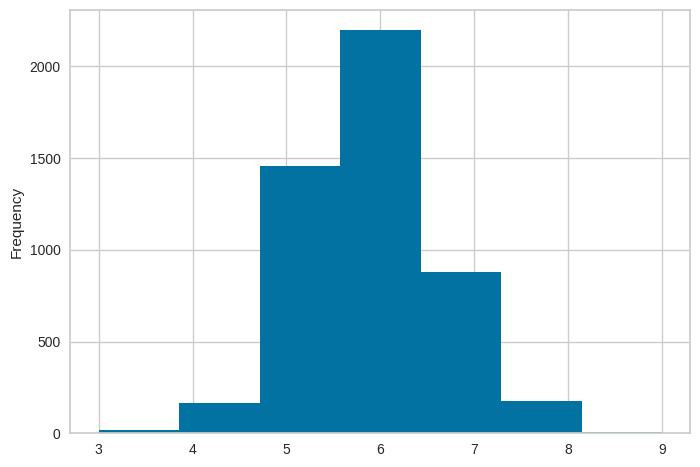

In [45]:
#Another look at quality distribution, using a histogram
df['quality'].plot.hist(bins=len(list_quality))
df['quality'].value_counts()

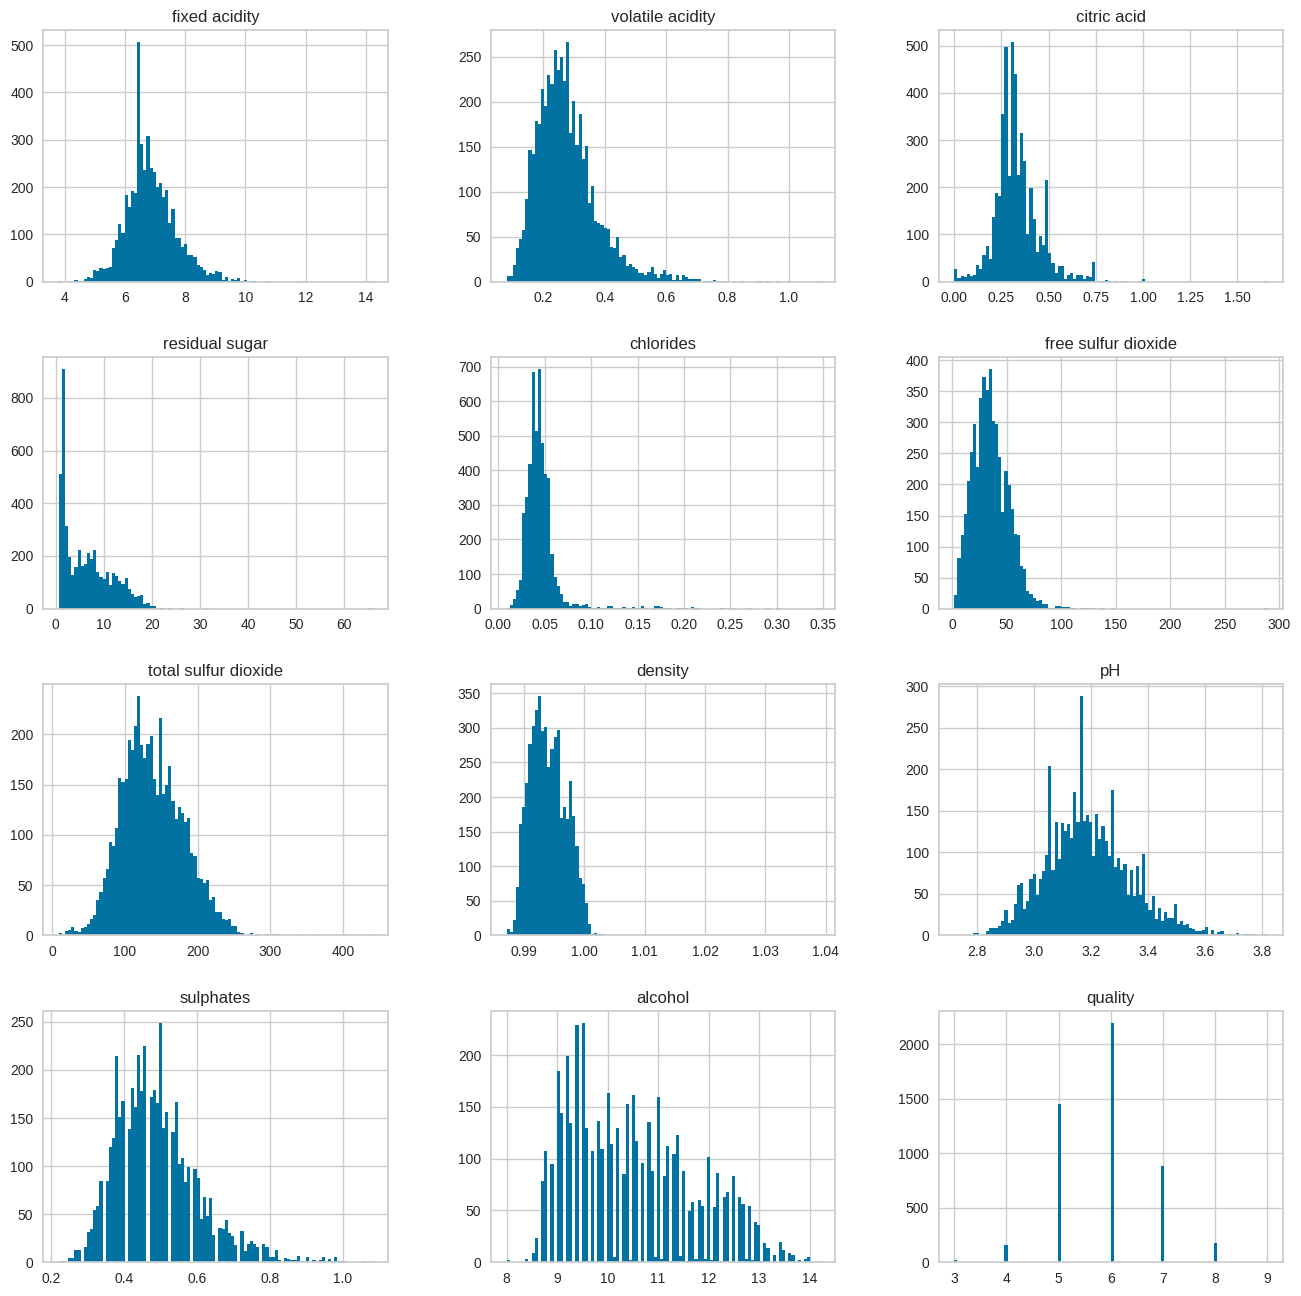

In [46]:
#Ploting histograms for all the continuous and categorical values

fig, axes = plt.subplots(len(df.columns)//3, 3, figsize=(16, 16))

i = 0
for triaxis in axes:
    for axis in triaxis:
        df.hist(column = df.columns[i], bins = 100, ax=axis)
        i = i+1

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


## Data Treatment

In [48]:
#Attempt 1 at altering the continuous values

valid_data = df.copy()
# for c in cont_names:
#     valid_data.loc[valid_data[c]>np.percentile(valid_data[c],95),c] = np.mean(df[c])
#     valid_data.loc[valid_data[c]<np.percentile(valid_data[c],5),c] = np.mean(df[c])

In [49]:
#Attempt 2 at altering the continuous values

# valid_data = df.copy()
# for c in cont_names:
#     valid_data.drop(valid_data.loc[valid_data[c]>np.percentile(valid_data[c],95),c].index,inplace=True)
#     valid_data.drop(valid_data.loc[valid_data[c]<np.percentile(valid_data[c],5),c].index,inplace=True)

In [50]:
#Altering the categorical values to better suit my purpose

valid_data.replace([3,4,5],0, inplace=True)
valid_data.replace([6,7,8,9],1,inplace=True)

## Predictive model creation

## Using Pycaret to find the best model

In [51]:
s = classification.setup(valid_data, target = 'quality', session_id=111)

,Description,Value
0,session_id,111
1,Target,quality
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4898, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [52]:
#Checking best models
best = classification.compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8320,0.9051,0.9102,0.8487,0.8782,0.6083,0.6131,0.2720
rf,Random Forest Classifier,0.8285,0.8925,0.9005,0.8510,0.8748,0.6029,0.6065,0.3880
lightgbm,Light Gradient Boosting Machine,0.8124,0.8644,0.8843,0.8422,0.8624,0.5679,0.5708,0.0730
gbc,Gradient Boosting Classifier,0.7777,0.8397,0.8668,0.8119,0.8383,0.4837,0.4870,0.2840
dt,Decision Tree Classifier,0.7631,0.7343,0.8212,0.8227,0.8218,0.4683,0.4686,0.0200
ada,Ada Boost Classifier,0.7503,0.8018,0.8506,0.7905,0.8190,0.4173,0.4216,0.1130
lda,Linear Discriminant Analysis,0.7310,0.7816,0.8795,0.7565,0.8132,0.3422,0.3558,0.0140
qda,Quadratic Discriminant Analysis,0.7121,0.7675,0.8747,0.7400,0.8016,0.2893,0.3039,0.0130
lr,Logistic Regression,0.7074,0.7542,0.9224,0.7182,0.8075,0.2346,0.2708,0.1750
ridge,Ridge Classifier,0.7025,0.0000,0.9246,0.7133,0.8053,0.2164,0.2537,0.0110


In [53]:
#I decided on the extra trees classifier because it seems to be the best

extra_trees = classification.create_model('et')
extra_trees

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8192,0.8787,0.9039,0.8381,0.8697,0.5759,0.5803
1,0.8484,0.9113,0.9520,0.8417,0.8934,0.6342,0.6488
2,0.8513,0.9277,0.9298,0.8583,0.8926,0.6522,0.6577
3,0.8251,0.9133,0.8904,0.8529,0.8712,0.5989,0.6003
4,0.8455,0.9326,0.9035,0.8692,0.8860,0.6465,0.6476
5,0.8397,0.9030,0.9167,0.8531,0.8837,0.6266,0.6308
6,0.8192,0.8952,0.8904,0.8458,0.8675,0.5837,0.5856
7,0.8251,0.8925,0.8816,0.8590,0.8701,0.6024,0.6029
8,0.8158,0.9003,0.9167,0.8261,0.8690,0.5615,0.5702


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=111, verbose=0,
                     warm_start=False)

## Using Sklearn to Build an ExtraTreeClassifier model

In [65]:
#Creating the model in sklearn

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification

X = valid_data.drop(columns=['quality'])
y = valid_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=111)


clf = ExtraTreesClassifier(n_estimators=100, random_state=111,n_jobs=-1)
clf.fit(X_train, y_train)




ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=111, verbose=0,
                     warm_start=False)

In [69]:
#Checking the score
clf.score(X_test,y_test)

0.8218923933209648

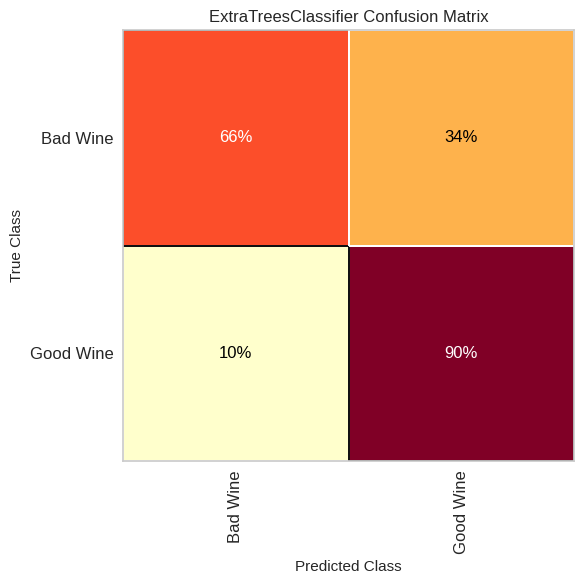

<Figure size 800x550 with 0 Axes>

In [72]:
plt.figure(figsize=(6, 6))
confusion_matrix(
    clf,
    X_train, y_train, X_test, y_test,
    percent=True, classes=['Bad Wine', 'Good Wine']
)
plt.tight_layout()

## Most important metrics

### Using Pycaret

### ROC curves

In [54]:
preds = predict_model(extra_trees, drift_report = True)

Extra Trees Classifier_Drift_Report_Classification.html saved successfully.


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8340,0.9018,0.9068,0.8526,0.8788,0.6161,0.6191


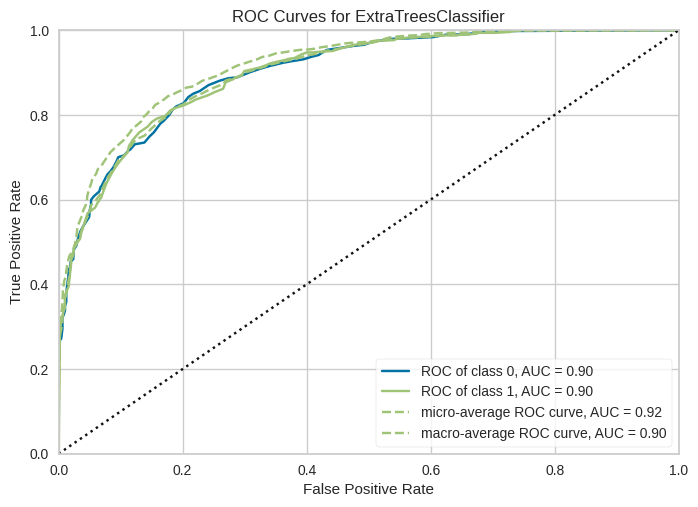

In [55]:
classification.plot_model(extra_trees, plot = 'auc')

### Precision recall curve

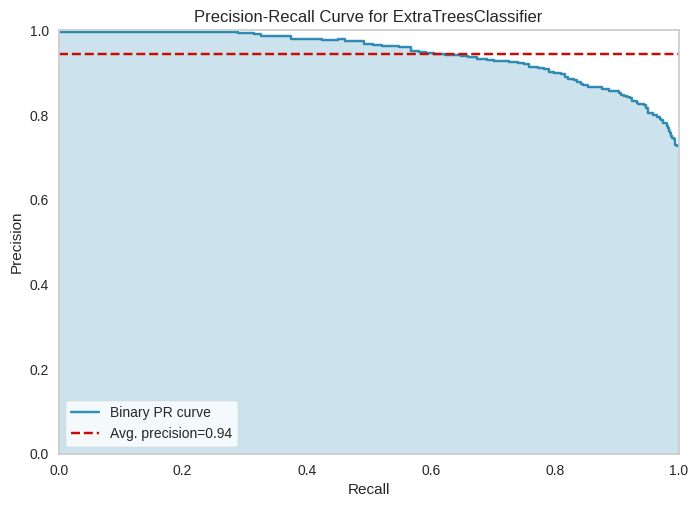

In [56]:
classification.plot_model(extra_trees, plot = 'pr')


### Model confusion matrix

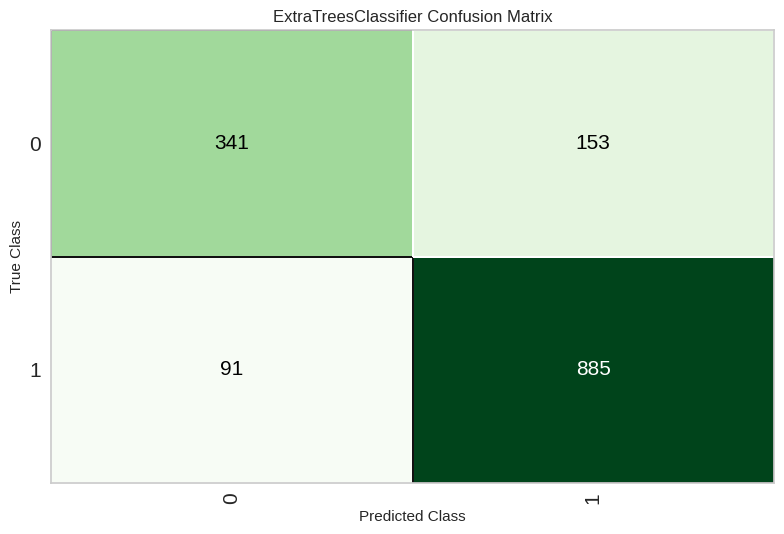

In [57]:
classification.plot_model(extra_trees, plot = 'confusion_matrix')


### Model error analysis

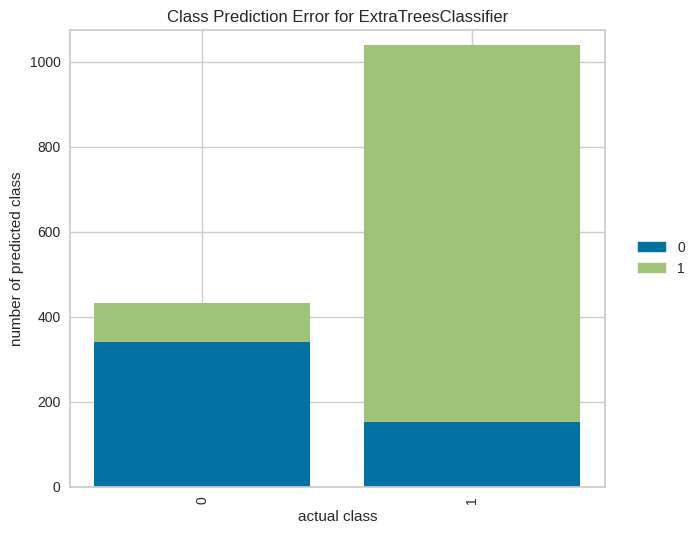

In [58]:
classification.plot_model(extra_trees, plot = 'error')

### Classification Report

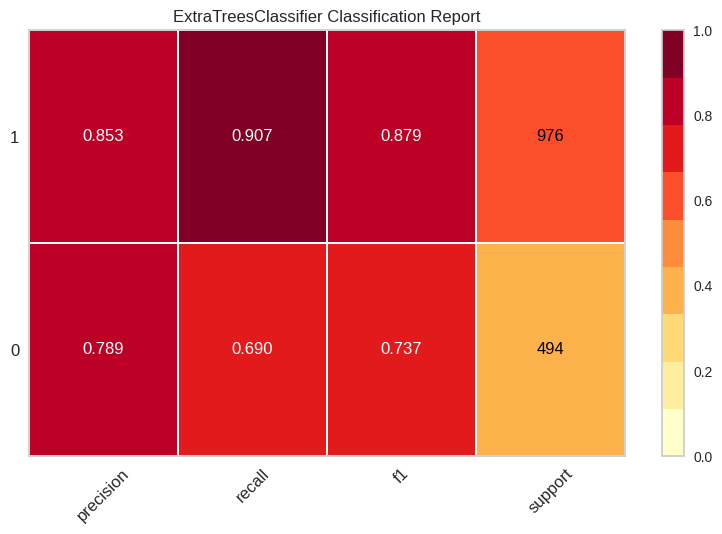

In [59]:
classification.plot_model(extra_trees, plot = 'class_report')

### Most important features

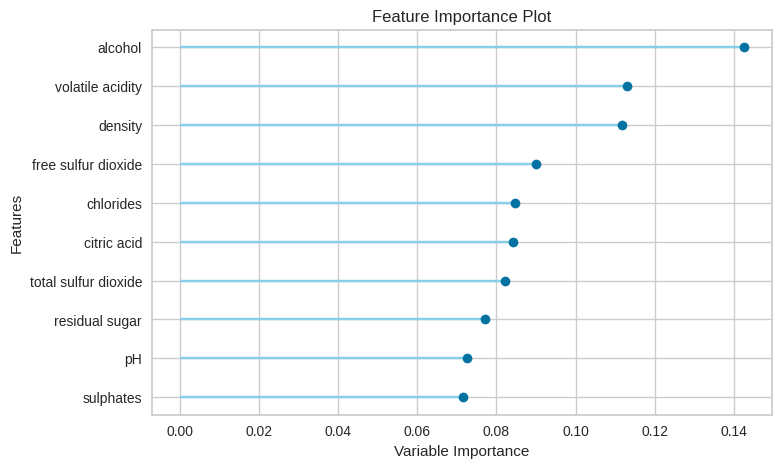

In [60]:
classification.plot_model(extra_trees, plot = 'feature')

### Model calibration

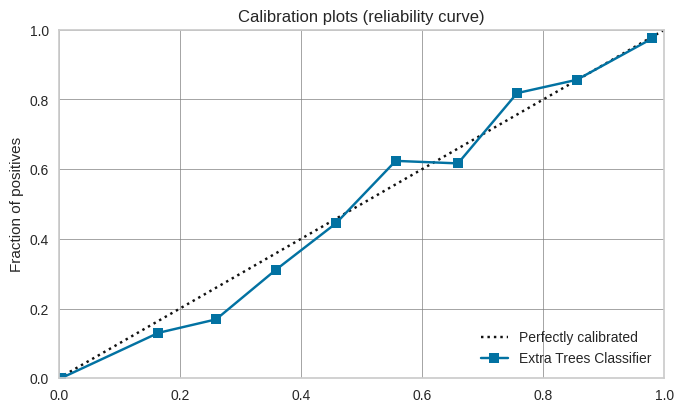

In [61]:
classification.plot_model(extra_trees, plot = 'calibration')
